In [1]:
import os, sys
import numpy as np
from astropy import units, constants
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model
import lmfit
from lightkurve.lightcurve import LightCurve
from plasmapy.formulary.radiation import thermal_bremsstrahlung

from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import find_lines_threshold,fit_lines,estimate_line_parameters
from astropy.modeling import models
from specutils.analysis import centroid, fwhm, equivalent_width, line_flux
from astropy.nddata import NDUncertainty

#from stella.utils import flare_lightcurve

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced2')

_, flare_orbits, flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask2.npy',
                                      allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')

distance = (9.72*units.pc).to(units.cm)

In [2]:
fwc = FlaresWithCOS(wavelength=np.append(w20, w30, axis=0), 
                    flux=np.append(f20, f30, axis=0),
                    flux_err=np.append(e20, e30, axis=0), 
                    time=np.append(t20, t30)-t20[0], 
                    orbit=np.append(o20, o30+5))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/arcticfox/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

default_mask = fwc.measure_FUV130()

for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

In [3]:
a = np.nansum(flare_mask,axis=0) == 0
all_med = np.nanmean(fwc.flux[a],axis=0)
flareb = np.nanmean(fwc.flux[flare_mask[1]>0],axis=0)

## Fitting a BB spectrum

In [4]:
from lmfit import Model

fwc.identify_continuum()
flux_units = fwc.flux_units

In [5]:
def bb(x, T, scaling):
    global flux_units
    T *= units.K
    x *= units.AA
    frac = 2.0 * constants.h * constants.c**2 / x**5
    exp = (constants.h * constants.c) / (x * constants.k_B * T)
    func =  frac * 1.0/(np.exp(exp) - 1.0)
    func = func.to(flux_units)
    return np.log10(func.value)*scaling

def photon_wavelength(E):
    w =  (constants.h * constants.c)/E
    return w.to(units.AA)

def L_to_flux(L, distance):
    F = L / (4 * np.pi * distance**2)
    return F.to(units.erg/units.s/units.cm**2)

def bremsstrahlung(x, T):#, offset):
    x /= units.s
    ne = 300 / units.m**3
    T *= units.K
    c = 10 * units.m**5 * (units.K)**(0.5) / units.s**4 * units.kg
    const = c * 4 * np.pi * ne**2 * T**(-0.5)
    frac =  - constants.h / (constants.k_B * T)
    expo = (constants.h * x) / (constants.k_B * T)
    
    brem = const * frac * np.exp(-expo)
    brem = (brem.to(units.W/units.m**3)).value
    brem = np.log10(brem - np.nanmin(brem))
    return brem #+ offset

def plasma_brem(x, Te, ne, scaling, offset):
    #print(x)
    spectrum = thermal_bremsstrahlung(x, ne*units.cm**-3, Te*units.K)
    s = spectrum.to(units.erg /units.s * units.s / units.cm ** 2 / units.AA)
    s = s/(25000*2*units.s)
    s = np.log10(s.value)*scaling+offset
    return s

### Fitting a blackbody to the data routine

In [6]:
def fit_bb(x, y, yerr):
    
    model = Model(bb)
    params = model.make_params()
    params['T'].set(value=10000, min=3000, max=50000)
    params['scaling'].set(value=-2, min=-200, max=100)
    
    result = model.fit(y,
                       params,
                       x=x,
                       nan_policy='omit',
                       max_nfev=5000)#,
                       #weights=1.0/yerr)
    minimize = result.minimize()
    
    bestfit= minimize.params['T'].value + 0.0
    stderr = minimize.params['T'].stderr + 0.0
    
    sfit = minimize.params['scaling'].value + 0.0
    serr = minimize.params['scaling'].stderr + 0.0
    
    upp1 = Model(bb)
    params_upp1 = upp1.make_params()
    params_upp1['T'].set(bestfit+stderr)
    params_upp1['scaling'].set(sfit)#+3*serr)
    
    low1 = Model(bb)
    params_low1 = upp1.make_params()
    params_low1['T'].set(bestfit-stderr)
    params_low1['scaling'].set(sfit)#-3*serr)
    
    return minimize, low1, params_low1, upp1, params_upp1, bestfit, stderr

### Fitting thermal bremstrahlung to the profile routine

In [89]:
def fit_brem(x, y, yerr):
    
    model = Model(plasma_brem)
    params = model.make_params()

    params['Te'].set(value=10**6, min=10**3, max=10**10)
    params['ne'].set(value=2.8e22, min=1e10, max=4e22)
    params['scaling'].set(value=200, min=1, max=10000)
    params['offset'].set(value=-5, min=-1000, max=1000)

    #f = (constants.c/(x*units.AA)).to(1.0/units.s)
    
    result = model.fit(y,
                       params,
                       x=x,
                       weights=1.0/yerr,
                       max_nfev=3000,
                       nan_policy='omit')
    minimize = result.minimize(max_nfev=5000)
    
    bestfit= minimize.params['Te'].value + 0.0
    try:
        stderr = minimize.params['Te'].stderr + 0.0
    except:
        stderr=0
    
    newx = np.linspace(x[0], x[-1], 100) 
    #f = (constants.c/newx).to(1.0/units.s)

    fit = plasma_brem(newx,  
                      minimize.params['Te'].value,
                      minimize.params['ne'].value,
                      minimize.params['scaling'].value,
                      minimize.params['offset'].value)
    print(minimize.params['Te'].value, minimize.params['ne'].value)
    return result, fit, newx, minimize.params['ne'].value, minimize.params['scaling'].value, minimize.params['offset'].value, bestfit, stderr, #sfit

In [90]:
qfm = np.where(flare_mask[2]!=0)[0]

In [91]:
all_bb_fits = []
all_brem_fits = []

for j,i in enumerate([-100, 2, 4,-4,-3,-1]):
    
    if i > -5:
        qfm = np.where(flare_mask[i]!=0)[0]
    else:
        qfm = np.where(np.nansum(flare_mask,axis=0)==0)[0]

    med = np.nanmean(fwc.flux[qfm], axis=0)
    std = np.log10(np.sqrt(np.nansum(fwc.flux_err[qfm]**2, axis=0)))/len(qfm)/np.log(10)
    
    cmask = np.nanmedian(fwc.continuum_mask[qfm],axis=0) == 0
    
    q = (med[cmask] > 0) & (fwc.wavelength[qfm[0]][cmask]>1100)
    
    binned = LightCurve(time=fwc.wavelength[qfm[0]][cmask][q], 
                        flux=np.log10(med[cmask][q]),
                        flux_err=std[cmask][q]).bin(time_bin_size=1).remove_nans()
    q = (med[cmask] > 0)
    binned_all = LightCurve(time=fwc.wavelength[qfm[0]][cmask][q], 
                            flux=np.log10(med[cmask][q]),
                        flux_err=std[cmask][q]).bin(time_bin_size=1).remove_nans()

    result, low1, params_low1, upp1, params_upp1, bestfit, stderr = fit_bb(x=binned.time.value,
                                                                           y=binned.flux.value,
                                                                           yerr=binned.flux_err.value)
    all_bb_fits.append([binned_all, result, bestfit])
    print('finished blackbody')
    
    if i > -5:
        short = binned_all.time.value <= 1110
        wavelengths = binned_all.time.value[short]*units.AA
        frequencies = (constants.c/wavelengths).to(units.Hz)
        (brem_result,bfit,bfit_x,best_ne, best_s, best_o,
         bfit_best,bfit_std) = fit_brem(x=frequencies,
                                        y=binned_all.flux.value[short],
                                        yerr=binned_all.flux_err.value[short])
        print('finished bremsstrahlung')
        all_brem_fits.append([bfit_x, bfit, best_ne, best_s,best_o, bfit_best,bfit_std])

finished blackbody
finished blackbody
1411205621.3990672 3.999999999992451e+22
finished bremsstrahlung
finished blackbody
1365366407.135277 3.999999993416565e+22
finished bremsstrahlung
finished blackbody
1327494193.4734514 3.999999999999555e+22
finished bremsstrahlung
finished blackbody
1457996767.0094357 3.999999864889027e+22
finished bremsstrahlung
finished blackbody


PhysicsError: Rayleigh-Jeans limit not satisfied: ℏω/kT_e = 3.31e-01 > 0.1. Try lower ω or higher T_e.

In [ ]:
label='{} +/- {} K'.format(int(np.round(all_bb_fits[0][1].params['T'].value,0)), 
                               int(np.round(all_bb_fits[0][1].params['T'].stderr,0)))
print(label)

In [51]:
tab = Table()
tab['wavelength'] = all_bb_fits[1][0].time
tab['log_flux'] = all_bb_fits[1][0].flux
tab['log_flux_err'] = all_bb_fits[1][0].flux_err

tab.write('/Users/arcticfox/Documents/GitHub/cos_flares/data/flare_b_continuum.txt',
          format='ascii', overwrite=True)

15643 +/- 448 K
1505815824.7247636
15658 +/- 522 K
9351467833.481598
14871 +/- 538 K
9660266314.180054
15233 +/- 408 K
4770554998.9581995
15738 +/- 487 K
1562113063.8606548


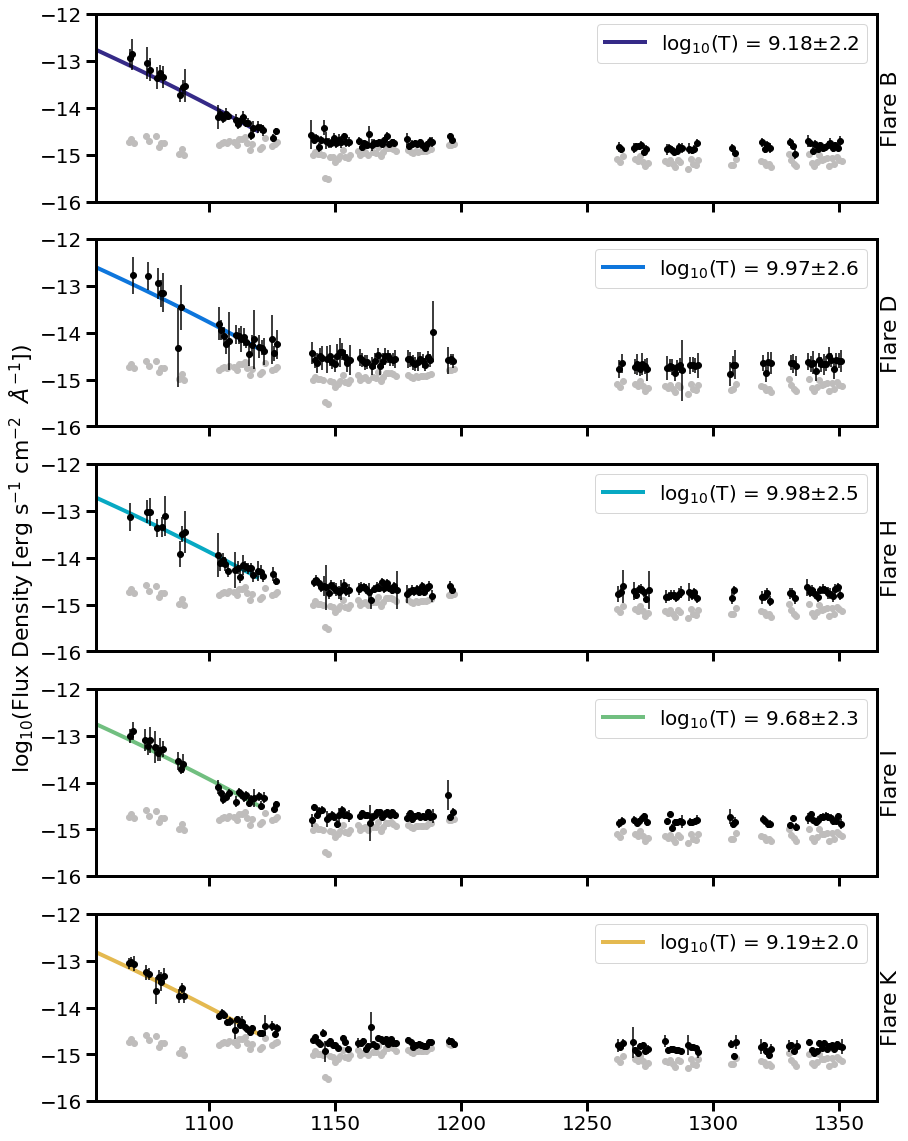

In [55]:
ion_colors = np.append('#878482', parula[np.linspace(0,200,5,dtype=int)])

fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(14,20), sharex=True, sharey=True)
laxes = axes.reshape(-1)


letters=['B', 'D', 'H', 'I', 'K']

for j,i in enumerate([1,3,-4,-3,-1]):
    
    
    #label='log(T) = {}'.format(np.round(np.log10(bestfit),2))
    laxes[j].errorbar(all_bb_fits[0][0].time.value, 
                      all_bb_fits[0][0].flux.value, 
                      all_bb_fits[0][0].flux_err.value,
                      marker='o', linestyle='', #label='Quiescent',
                      color='#bfbdbc', zorder=1, markeredgecolor=None)
    
    laxes[j].errorbar(all_bb_fits[j+1][0].time.value, 
                      all_bb_fits[j+1][0].flux.value, 
                      all_bb_fits[j+1][0].flux_err.value, #label='In-Flare',
                      marker='o', linestyle='', color='k', zorder=2)

    label='{} +/- {} K'.format(int(np.round(all_bb_fits[j+1][1].params['T'].value,0)), 
                               int(np.round(all_bb_fits[j+1][1].params['T'].stderr,0)))
    print(label)
    
    if i > -5:
        brem_w = (constants.c/all_brem_fits[j][0]).to(units.AA)
        u = brem_w.value < 1120
        err = np.log10(all_brem_fits[j][-1]/(all_brem_fits[j][-2]))
        print(all_brem_fits[j][-2])
        label = 'log$_{10}$(T) = ' + str(np.round(np.log10(all_brem_fits[j][-2]),2))
        label += '$\pm$'
        label += str(np.round(err,1))
        laxes[j].plot(brem_w[u], all_brem_fits[j][1][u], lw=4, 
                      zorder=1, color=ion_colors[j+1],
                      label=label)

    laxes[j].legend()
    
    ax2 = laxes[j].twinx()
    
    if i > -5:
        ax2.set_ylabel('Flare {}'.format(letters[j]), fontsize=22)
    else:
        ax2.set_ylabel(letters[j], fontsize=22)
        
    ax2.set_yticks([])

    
    if j == 2:
        laxes[j].set_ylabel('log$_{10}$(Flux Density [erg s$^{-1}$ cm$^{-2}$  $\AA^{-1}$])',
                            fontsize=22)
    if j == 5:
        laxes[j].set_xlabel('Wavelength [$\AA$]', fontsize=22)
    laxes[j].set_rasterized(True)
    laxes[j].set_ylim(-16,-12)
    laxes[j].set_xlim(1055, 1365)
    
plt.subplots_adjust(hspace=0.2)

#plt.savefig('/Users/arcticfox/Documents/AUMic/paper/bbs.pdf',
#            rasterize=True, dpi=300, bbox_inches='tight')

In [60]:
tab = Table()
tab['wavelength'] = (constants.c/all_brem_fits[0][0]).to(units.AA)
tab['brem_fit'] = all_brem_fits[0][1]

In [62]:
tab.write('/Users/arcticfox/Documents/AUMic/bremfit.csv', format='csv')

In [76]:
tab = Table()
tab['wavelength'] =binned_all.time
tab['log_flux'] = binned_all.flux
tab['log_flux_error'] = binned_all.flux_err

## Combining with FUSE

In [137]:
fwc.identify_continuum()

In [237]:
b1 = np.linspace(1075,1150,5)
b2 = np.linspace(1075+np.nanmedian(np.diff(b1)),1150+np.nanmedian(np.diff(b1)),5)

np.vstack([b1,b2]).T

array([[1075.  , 1093.75],
       [1093.75, 1112.5 ],
       [1112.5 , 1131.25],
       [1131.25, 1150.  ],
       [1150.  , 1168.75]])

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_42454/3318893385.py:18: RuntimeWarning: Mean of empty slice
  cont = np.nanmean(flux[m], axis=0)
/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_42454/3318893385.py:27: RuntimeWarning: Mean of empty slice
  med = np.nanmean(flux[m], axis=0)[c]
/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_42454/3318893385.py:18: RuntimeWarning: Mean of empty slice
  cont = np.nanmean(flux[m], axis=0)
/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_42454/3318893385.py:27: RuntimeWarning: Mean of empty slice
  med = np.nanmean(flux[m], axis=0)[c]
/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var

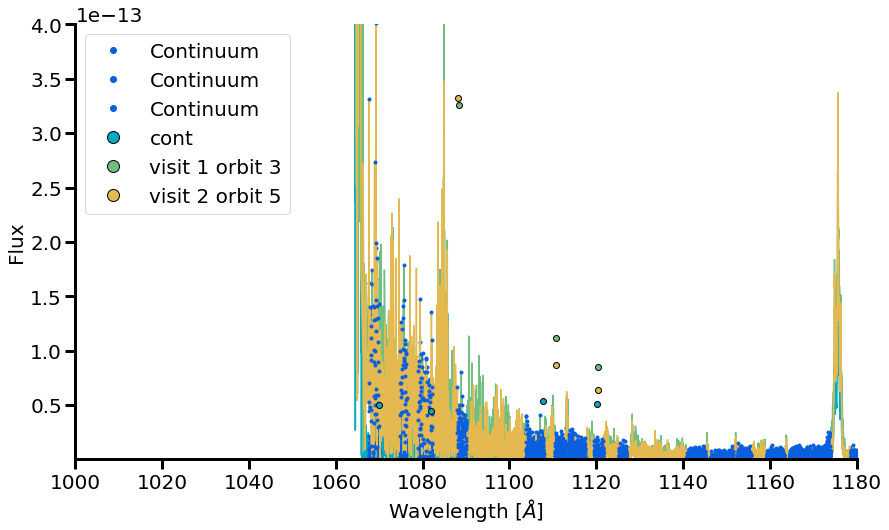

In [258]:
plt.figure(figsize=(14,8))

# [2,-4,-3,-2,-1]

masks = [np.nansum(flare_mask,axis=0)==0,
             flare_mask[1]>0,
             np.nansum(flare_mask[np.arange(-4,0,1)],axis=0)>0]
b1 = np.linspace(1066,1115,5)
b2 = np.linspace(1066+np.nanmedian(np.diff(b1)),1115+np.nanmedian(np.diff(b1)),5)
blue_mask = np.vstack([b1,b2]).T
labels = ['cont', 'visit 1 orbit 3', 'visit 2 orbit 5']
cont_lc = np.zeros((3,len(blue_mask),3))


x = 100
for j,m in enumerate(masks):

    cont = np.nanmean(flux[m], axis=0)

    q = (cont > 0) 
    c = (cont>0) & (fwc.continuum_mask[0]==0)

    plt.plot(fwc.wavelength[0][q], cont[q], parula[x])
    plt.plot(fwc.wavelength[0][c], cont[c],'.', label='Continuum', c=parula[30])

    #####
    med = np.nanmean(flux[m], axis=0)[c]
    med_err = np.sqrt(np.nansum(fwc.flux_err[m]**2,axis=0)[c])/len(mask)

    q = (med > 0) 

    for i, bmask in enumerate(blue_mask):

        cnew = ((fwc.wavelength[0][c]>=blue_mask[i][0]) & 
                (fwc.wavelength[0][c]<=blue_mask[i][1]) & (med>0))
        
        fsum = np.trapz(med[cnew]*fwc.flux_units, x=fwc.wavelength[0][c][cnew]*units.AA)
        
        esum = np.sqrt(np.nansum(med_err[cnew]**2)/len(c))
        medw = np.nanmedian(fwc.wavelength[0][c][cnew])
        
        if i == 0:
            plt.errorbar(medw,
                         fsum.value, #yerr=esum,
                         color=parula[x], marker='o', linestyle='', label=labels[j],
                         markeredgecolor='k')
        else:
            plt.errorbar(medw, fsum.value, #yerr=esum,
                         color=parula[x], marker='o', linestyle='', 
                         markeredgecolor='k')
        cont_lc[j][i] = [medw,fsum.value,esum]

    x += 50


    #plt.yscale('log')
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Flux')
    plt.xlim(1000,1180)
    plt.ylim(1e-18,4e-13)

    plt.legend()
    #plt.savefig('/Users/arcticfox/Documents/AUMic/figures/continuum_region.png', rasterize=True,
    #            dpi=300, bbox_inches='tight')#, transparent=True)

1070.031099528831 1120.2271150499532
-0.0012965082420767701
--
1069.8864563182235 1120.3380081780856
0.8771810421330393
--
1069.7466345479697 1120.3524724991464
0.7316943854613588
--
955.076495132128 1104.8678720445064
0.0074029126213592256
--
955.076495132128 1104.8678720445064
0.003519417475728155
--
955.4937413073714 1104.8678720445064
-0.00018203883495145762
--


Text(0.5, 0, 'Wavelength [$\\AA$]')

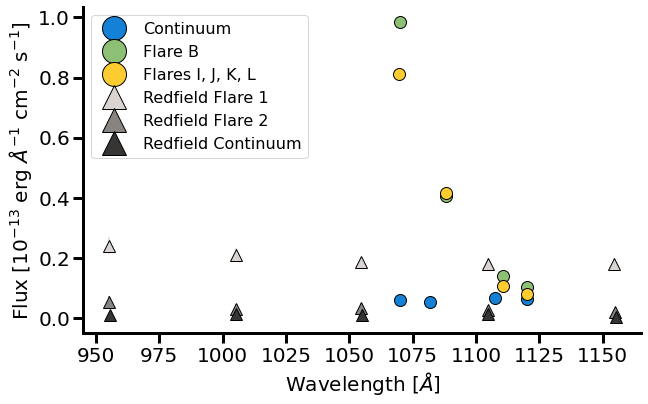

In [313]:
fig = plt.figure(figsize=(10,6))
fig.set_facecolor('w')
markers = ['o', '^', 's']
ty = np.unique(redfield['type'])
x = 30

labels = ['Continuum', 'Flare B', 'Flares I, J, K, L']
labels_red = ['Redfield Flare 1', 'Redfield Flare 2', 'Redfield Continuum']
cc = [parula[60], parula[160], parula[225]]
if COLOR == 'k':
    cc_red = ['#d9d4d1', '#878482', '#363534']
else:
    cc_red = [ 'w','#d9d4d1', '#878482']

for i in range(len(cont_lc)):
    #if i > 0:
    #   scale=6*10**-13
    #else:
    scale=8*10**-13
    plt.errorbar(cont_lc[i][:,0], 
                 cont_lc[i][:,1]/scale, 
                 yerr=cont_lc[i][:,2]/scale,
                 marker='o', linestyle='', ms=12,
                 color=cc[i], label=labels[i], markeredgecolor='k',zorder=10)
    print(cont_lc[i][:,0][0],cont_lc[i][:,0][-1])
    print(cont_lc[i][:,1][0]/scale - cont_lc[i][:,1][-1]/scale)
    print('--')
    
print('===========')
for i in range(3):
    subtab = redfield[redfield['type']==ty[i]]
    stq = ((subtab['wavelength']>=blue_mask[3][0]) & (subtab['wavelength']<=blue_mask[3][1]))
    t1 = (subtab['flux'][stq]/ cont_lc[i][-2,1])

    plt.errorbar(subtab['wavelength'], 
                 subtab['flux']/10**-13,
                 yerr=[(subtab['flux']-subtab['y_low'])/10**-13, 
                       (subtab['y_upp']-subtab['flux'])/10**-13],
                 linestyle='', color=cc_red[i], ms=12,
                 marker='^', label=labels_red[i], markeredgecolor='k')
    print(subtab['wavelength'][0], subtab['wavelength'][-2])
    print(subtab['flux'][0]/scale - subtab['flux'][-2]/scale)
    print('--')
    x += 80
    
plt.legend(fontsize=16,ncol=1)
plt.ylabel('Flux [$10^{-13}$ erg $\AA^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.xlabel('Wavelength [$\AA$]')
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/fuse_lightcurves.png', rasterize=True,
#            dpi=300, bbox_inches='tight', transparent=True)

In [294]:
cont_lc[i][:,1]/scale

array([0.81166692, 0.41565517, 0.        , 0.10865328, 0.07997253])

In [280]:
(cont_lc[0][0][1]-cont_lc[0][-1][1])/cont_lc[0][-1][1]

-0.02050287708540275

In [284]:
(cont_lc[1][0][1],cont_lc[1][-1][1])

(7.862905992753885e-13, 8.454576556895706e-14)

In [283]:
(cont_lc[1][0][1]-cont_lc[1][-1][1])/cont_lc[1][-1][1]

8.300177176041721

## Looking at counts

In [171]:
path1 = '/Users/arcticfox/Documents/AUMic/30s/reduced/a'
path2 = '/Users/arcticfox/Documents/AUMic/30s/reduced2/b'

In [173]:
def get_counts(path):
    files = np.sort([os.path.join(path, i) for i in os.listdir(path) if
                 i.endswith('x1d.fits')])

    for i,fn in enumerate(files):
        hdu = fits.open(fn)
        #print(hdu[1].data['WAVELENGTH'][1],hdu[1].data['WAVELENGTH'][0])
        wavelength = np.append(hdu[1].data['WAVELENGTH'][1], hdu[1].data['WAVELENGTH'][0])
        c = np.append(hdu[1].data['GCOUNTS'][1], hdu[1].data['GCOUNTS'][0])
        
        if i == 0:
            wave = np.zeros((len(files), len(wavelength)))
            counts = np.zeros((len(files), len(wavelength)))

        wave[i] = wavelength + 0.0
        counts[i] = c + 0.0

        hdu.close()
    wave = np.array(wave)
    counts = np.array(counts)
    sum2 = np.zeros(len(files))
    for i in range(len(wave)):
        sum2[i] = np.nansum(counts[i])

    return wave, counts, sum2

In [174]:
w1, c1, s1 = get_counts(path1)
w2, c2, s2 = get_counts(path2)

KeyboardInterrupt: 

In [ ]:
plt.plot(fwc.time[:len(s1)], s1)
plt.plot(fwc.time[:len(s1)],s2)

In [ ]:
fwc.line_table[fwc.line_table['ion']=='CIII']

In [ ]:
main_ions = ['SiII', 'SiIII', 'CIII', 'NV_1', 'FeXXI']

fig, (ax1,ax2) = plt.subplots(ncols=1,nrows=2,figsize=(10,10))
fig.set_facecolor('w')

for i in range(2):
    for n,ion in enumerate(main_ions):
        v, _ = fwc.to_velocity(wave=w1[0], 
                               mid=fwc.line_table[fwc.line_table['ion']==ion]['wave_c'][0])
        vmask = ( (v.value >= fwc.line_table[fwc.line_table['ion']==ion]['vmin'][0]) & 
                  (v.value <= fwc.line_table[fwc.line_table['ion']==ion]['vmax'][0]))

        args = np.where(vmask==True)[0]
        
        if i == 0:
            key_counts = np.nansum(c1[:,args],axis=1)
            cont_args = np.where((np.nansum(flare_mask[:,fwc.orbit<5],axis=0)==0) & 
                             (key_counts>0))[0]
            ax1.plot(fwc.time[fwc.orbit<5], 
                          key_counts/np.nanmedian(key_counts[cont_args]), marker='o',
                     label=ion, c=ion_colors[n])
            ax1.set_xlim(11000,13500)
            ax1.set_ylabel('Counts')
        else:
            key_counts = np.nansum(c2[:,args],axis=1)
            cont_args = np.where((np.nansum(flare_mask[:,fwc.orbit>4],axis=0)==0) & 
                             (key_counts>0))[0]
            ax2.plot(fwc.time[fwc.orbit>4], 
                          key_counts/np.nanmedian(key_counts[cont_args]), 
                     marker='o', c=ion_colors[n])

            ax2.set_xlim(fwc.time[fwc.orbit==9][0].value, 
                              fwc.time[fwc.orbit==9][-1].value)
            ax2.set_ylabel('Counts')
            ax2.set_xlabel('Time - T$_0$ [s]')
ax1.legend(ncol=2)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/flare_in_counts.png', rasterize=True,
#            dpi=300, bbox_inches='tight')#, transparent=True)

/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_6789/1749072012.py:30: RuntimeWarning: divide by zero encountered in log10
  brem = np.log10(brem - np.nanmin(brem))


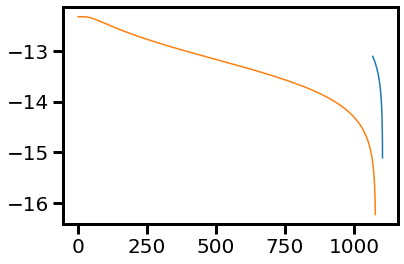

In [117]:
x = np.arange(0,1080,1)*units.AA
f = (constants.c/x).to(1.0/units.s)*units.s
b = bremsstrahlung(f, 10**6)

plt.plot(all_brem_fits[0][0], all_brem_fits[0][1])
plt.plot(x, b)